In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.cluster import KMeans

import sys
import os

sys.path.append(os.path.abspath('../src'))
import utils as util


cores_personalizadas = [util.barra_azul, util.barra_vermelha, util.barra_verde_escuro, util.barra_verde_claro]

df = pd.read_csv('../data/databaseElisa.csv', sep=';', decimal=',', thousands='.', 
                 index_col=None)

df['data'] = pd.to_datetime(df['data'], dayfirst=True, errors='coerce')
df.columns = df.columns.str.strip().str.lower()

df.head()

,data,fazenda,almoco,janta,cafe,lanche,vlralmoco,vlrjanta,vlrcafe,vlrlanche,total
0,2021-01-01,Santa Elisa,7,7,7,0,13.5,13.5,6.0,6.0,231.0
1,2021-01-01,Silo,2,2,2,0,13.5,13.5,6.0,6.0,66.0
2,2021-01-02,Santa Elisa,49,21,80,0,13.5,13.5,6.0,6.0,1425.0
3,2021-01-02,Silo,4,2,2,0,13.5,13.5,6.0,6.0,93.0
4,2021-01-03,Santa Elisa,35,35,30,0,13.5,13.5,6.0,6.0,1125.0


In [2]:
# Utilizando a função generate_metadata para gerar os metadados do dataframe
util.generate_metadata(df)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,data,datetime64[ns],0,0.0,1535
1,almoco,int64,0,0.0,343
2,janta,int64,0,0.0,236
3,cafe,int64,0,0.0,317
4,lanche,int64,0,0.0,68
5,vlralmoco,float64,0,0.0,5
6,vlrjanta,float64,0,0.0,5
7,vlrcafe,float64,0,0.0,5
8,vlrlanche,float64,0,0.0,5
9,total,float64,0,0.0,2718


In [3]:
# Filtrando os dados a partir de data selecionada
data_inicio = pd.Timestamp('2025-04-01')
df_filtrado = df[df['data'] >= data_inicio].copy()

In [4]:
df_filtrado.head()

,data,fazenda,almoco,janta,cafe,lanche,vlralmoco,vlrjanta,vlrcafe,vlrlanche,total
2984,2025-04-01,Santa Elisa,6,1,0,0,20.0,20.0,8.5,8.5,140.0
2985,2025-04-01,Silo,25,7,25,2,20.0,20.0,8.5,8.5,869.5
2986,2025-04-02,Santa Elisa,7,1,0,0,20.0,20.0,8.5,8.5,160.0
2987,2025-04-02,Silo,21,8,25,4,20.0,20.0,8.5,8.5,826.5
2988,2025-04-03,Santa Elisa,6,1,0,0,20.0,20.0,8.5,8.5,140.0


In [5]:
df_filtrado.tail()

,data,fazenda,almoco,janta,cafe,lanche,vlralmoco,vlrjanta,vlrcafe,vlrlanche,total
3065,2025-05-11,Silo,5,6,5,0,20.0,20.0,8.5,8.5,262.5
3066,2025-05-12,Santa Elisa,5,1,6,1,20.0,20.0,8.5,8.5,179.5
3067,2025-05-12,Silo,12,6,14,0,20.0,20.0,8.5,8.5,479.0
3068,2025-05-13,Santa Elisa,9,2,6,1,20.0,20.0,8.5,8.5,279.5
3069,2025-05-13,Silo,12,6,14,0,20.0,20.0,8.5,8.5,479.0


In [6]:
# Utilizando a função generate_metadata para gerar os metadados do dataframe
util.generate_metadata(df_filtrado)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,data,datetime64[ns],0,0.0,43
1,almoco,int64,0,0.0,25
2,janta,int64,0,0.0,9
3,cafe,int64,0,0.0,15
4,lanche,int64,0,0.0,6
5,vlralmoco,float64,0,0.0,1
6,vlrjanta,float64,0,0.0,1
7,vlrcafe,float64,0,0.0,1
8,vlrlanche,float64,0,0.0,1
9,total,float64,0,0.0,64


In [7]:
cols_to_describe = ['almoco', 'janta', 'cafe', 'lanche', 'vlralmoco', 'vlrjanta', 'vlrcafe', 'vlrlanche', 'total']

df_filtrado[cols_to_describe].describe()

,almoco,janta,cafe,lanche,vlralmoco,vlrjanta,vlrcafe,vlrlanche,total
count,86.000000,86.000000,86.000000,86.000000,86.0,86.0,86.0,86.0,86.000000
mean,10.023256,3.720930,10.732558,0.383721,20.0,20.0,8.5,8.5,369.372093
std,6.444289,2.742481,9.927294,1.294046,0.0,0.0,0.0,0.0,253.641644
min,0.000000,0.000000,0.000000,0.000000,20.0,20.0,8.5,8.5,0.000000
25%,5.000000,1.000000,0.000000,0.000000,20.0,20.0,8.5,8.5,160.000000
50%,9.000000,4.000000,8.500000,0.000000,20.0,20.0,8.5,8.5,342.000000
75%,14.750000,6.000000,20.000000,0.000000,20.0,20.0,8.5,8.5,590.000000
max,26.000000,8.000000,28.000000,10.000000,20.0,20.0,8.5,8.5,901.000000


In [8]:
util.lista_valores_unicos(df_filtrado, 'fazenda')

,Coluna,Categoria,Cardinalidade,Porcentagem
0,fazenda,Santa Elisa,43,50.00%
1,fazenda,Silo,43,50.00%


### Média Diária de Refeições por Fazenda

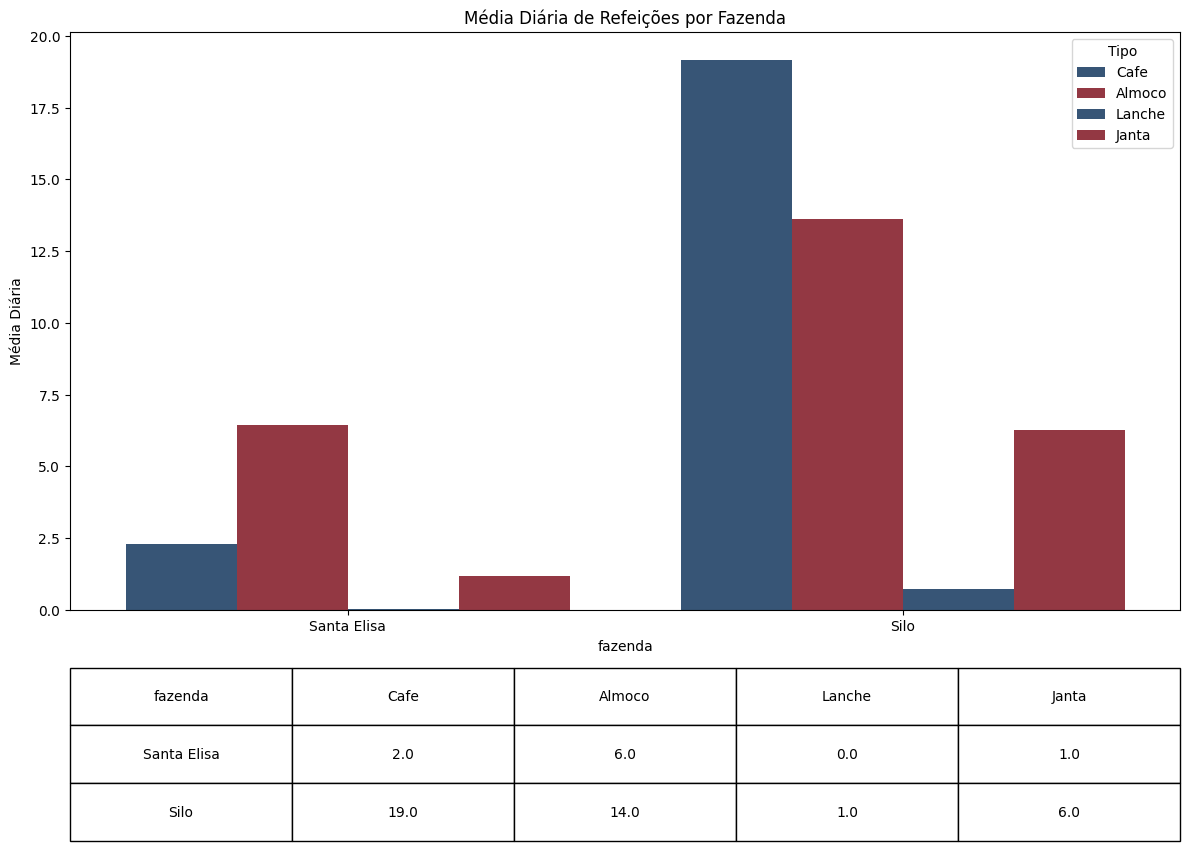

In [9]:
qtd_cols = ['cafe', 'almoco', 'lanche', 'janta']

# Calcular média diária por fazenda
df_media_diaria = df_filtrado.groupby('fazenda')[qtd_cols].mean().reset_index()
df_media_diaria = df_media_diaria.melt(id_vars='fazenda', var_name='Tipo', value_name='Média Diária')
df_media_diaria['Tipo'] = df_media_diaria['Tipo'].str.capitalize()

# Gráfico de barras
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=df_media_diaria, x='fazenda', y='Média Diária', hue='Tipo',
            palette=[util.barra_azul, util.barra_vermelha]*2, ax=ax)
ax.set_title('Média Diária de Refeições por Fazenda')

# Tabela reorganizada com colunas na ordem desejada
# Pivot e reordenar
df_tabela = df_media_diaria.pivot(index='fazenda', columns='Tipo', values='Média Diária').reset_index()
df_tabela.columns.name = None  # remove o nome "Tipo" das colunas

# Reordena as colunas conforme qtd_cols
ordem_colunas = ['fazenda'] + [x.capitalize() for x in qtd_cols]
df_tabela = df_tabela[ordem_colunas].round(0)

# Criar tabela abaixo do gráfico
table = plt.table(cellText=df_tabela.values,
                  colLabels=df_tabela.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0.0, -0.4, 1, 0.3])

plt.subplots_adjust(bottom=0.35)
plt.tight_layout()
plt.show()



#### Média Diária de Quantidade Refeições por Dia da Semana

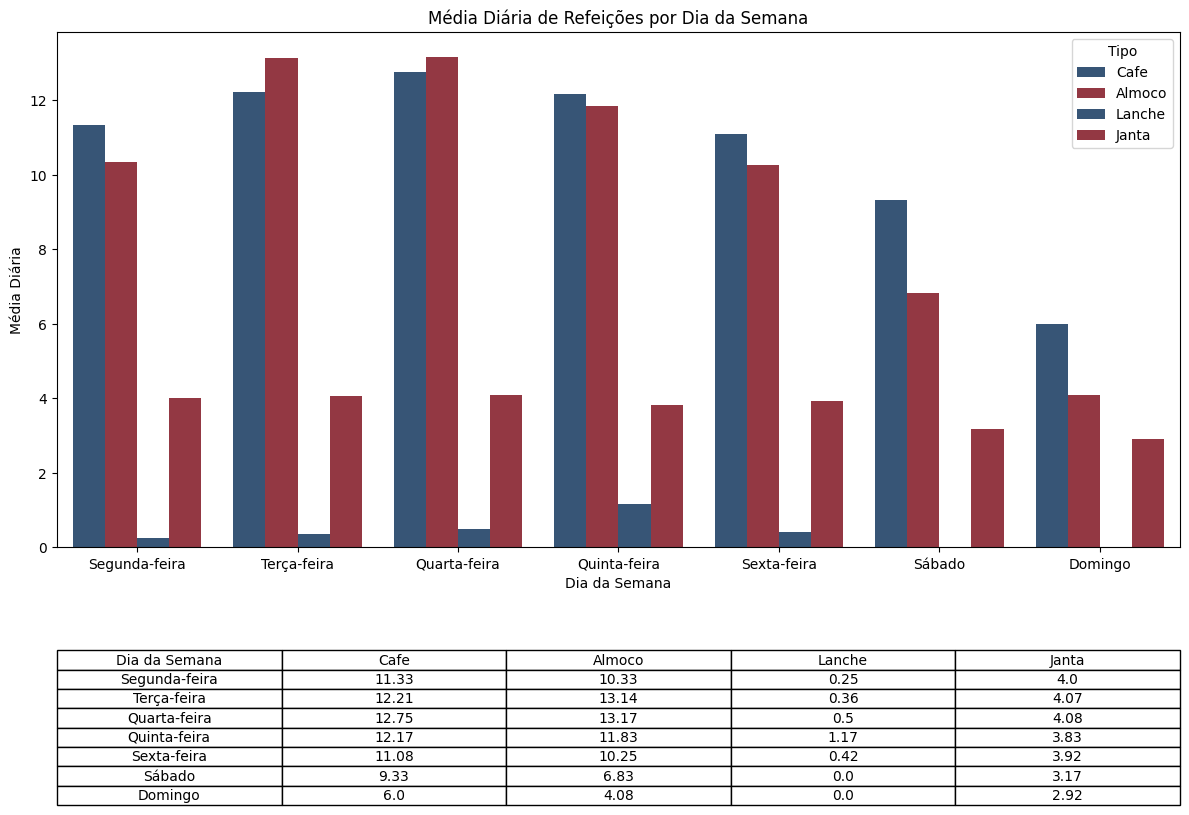

In [10]:
qtd_cols = ['cafe', 'almoco', 'lanche', 'janta']

# Certifique-se que df_filtrado e util.traducao_dias já existem

# Criar coluna dia da semana traduzida e ordenar
df_filtrado['dia_semana'] = df_filtrado['data'].dt.day_name()
df_media_semana = df_filtrado.groupby('dia_semana')[qtd_cols].mean().reset_index()
df_media_semana['dia_semana'] = df_media_semana['dia_semana'].map(util.traducao_dias)

ordem_dias_pt = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira',
                 'Sexta-feira', 'Sábado', 'Domingo']
df_media_semana['dia_semana'] = pd.Categorical(df_media_semana['dia_semana'],
                                              categories=ordem_dias_pt, ordered=True)
df_media_semana = df_media_semana.sort_values('dia_semana')

# Preparar dados para gráfico
df_melted = df_media_semana.melt(id_vars='dia_semana', var_name='Tipo', value_name='Média Diária')
df_melted['Tipo'] = df_melted['Tipo'].str.capitalize()

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=df_melted, x='dia_semana', y='Média Diária', hue='Tipo',
            palette=[util.barra_azul, util.barra_vermelha]*2, ax=ax)
ax.set_title('Média Diária de Refeições por Dia da Semana')
ax.set_xlabel('Dia da Semana')
ax.set_ylabel('Média Diária')
plt.xticks(rotation=0)

# Preparar tabela
df_tabela = df_media_semana.copy()
df_tabela.columns = ['Dia da Semana', 'Cafe', 'Almoco', 'Lanche', 'Janta']
df_tabela = df_tabela.round(2)

# Criar tabela abaixo do gráfico
table = plt.table(cellText=df_tabela.values,
                  colLabels=df_tabela.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.5, 1, 0.3])

plt.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()

### Top 5 Datas com Maior Venda Total (R$)

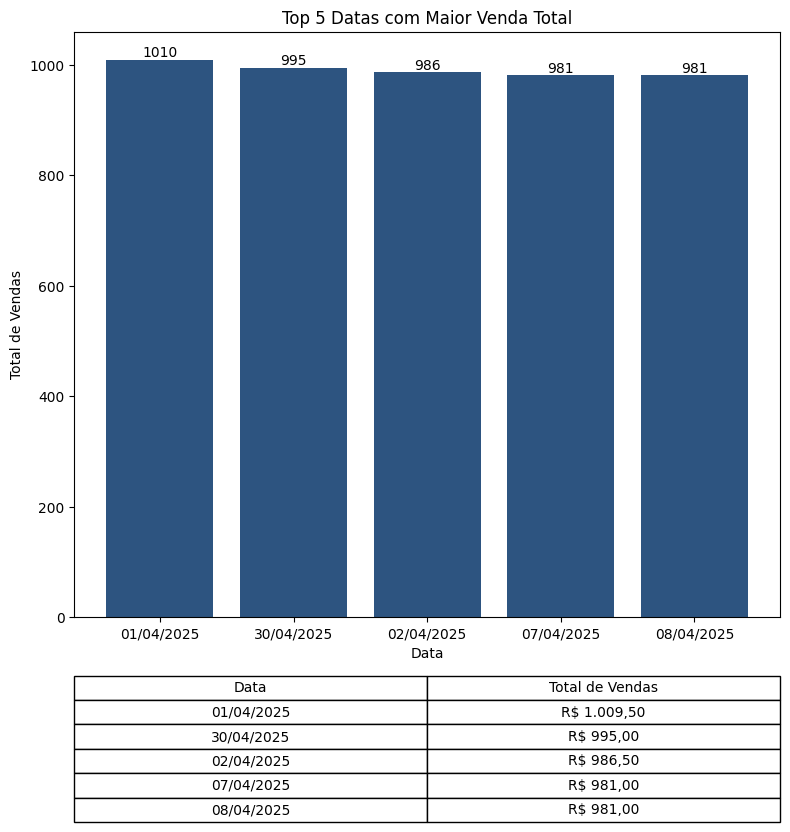

In [11]:
# Dados já prontos
df_top_vendas = df_filtrado.groupby('data')['total'].sum().nlargest(5).reset_index()

# Formatar valores e datas para exibição
df_top_vendas['total_formatado'] = df_top_vendas['total'].round(2).map(util.formata_para_brl)
df_top_vendas['data_str'] = df_top_vendas['data'].dt.strftime('%d/%m/%Y')

# Criar figura com espaço para gráfico e tabela
fig, ax = plt.subplots(figsize=(8, 8))

# Plotar gráfico de barras
bars = ax.bar(df_top_vendas['data_str'], df_top_vendas['total'], color=util.barra_azul)
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.0f}',
            ha='center', va='bottom')

ax.set_title('Top 5 Datas com Maior Venda Total')
ax.set_xlabel('Data')
ax.set_ylabel('Total de Vendas')
plt.xticks(rotation=0)

# Tabela com dados formatados
df_tabela = df_top_vendas[['data_str', 'total_formatado']]
df_tabela.columns = ['Data', 'Total de Vendas']

# Adicionar tabela abaixo do gráfico
table = plt.table(cellText=df_tabela.values,
                  colLabels=df_tabela.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0.0, -0.35, 1, 0.25])

plt.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()



### Top 5 dias com Maior Venda Total por Fazenda (R$)

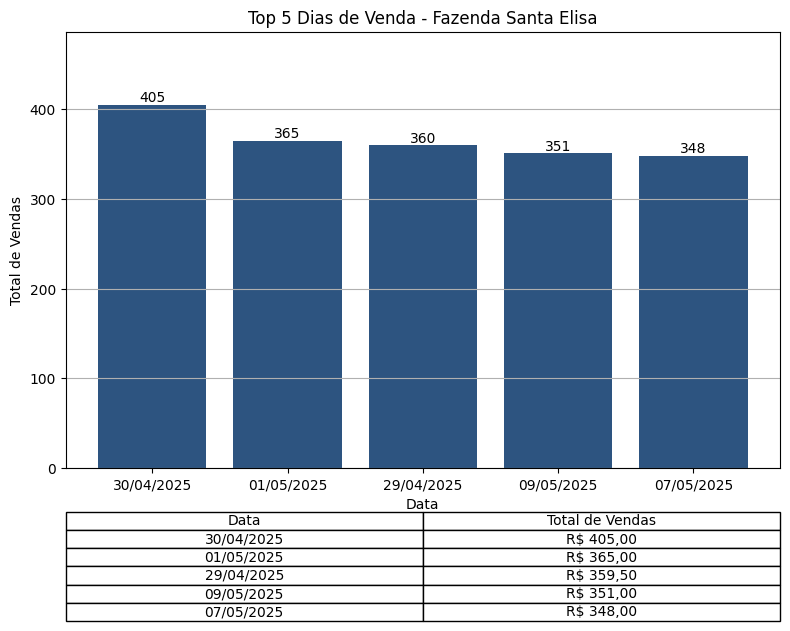

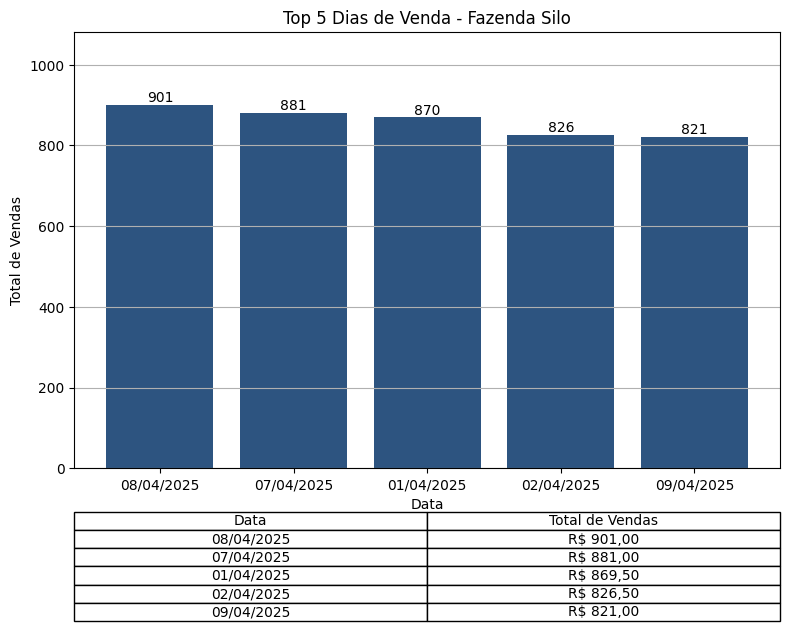

In [12]:
for fazenda in df_filtrado['fazenda'].unique():
    # Filtrar e preparar dados
    top5 = df_filtrado[df_filtrado['fazenda'] == fazenda].sort_values('total', ascending=False).head(5).copy()
    top5['Data'] = pd.to_datetime(top5['data']).dt.strftime('%d/%m/%Y')
    top5['Total de Vendas'] = top5['total'].round(2).map(util.formata_para_brl)

    # Criar figura individual para cada fazenda
    fig, ax = plt.subplots(figsize=(8, 6))

    # Gráfico de barras
    bars = ax.bar(top5['Data'], top5['total'], color=util.barra_azul)
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.0f}',
                ha='center', va='bottom')

    ax.set_title(f'Top 5 Dias de Venda - Fazenda {fazenda}')
    ax.set_xlabel('Data')
    ax.set_ylabel('Total de Vendas')
    ax.set_ylim(0, top5['total'].max() * 1.2)
    ax.grid(axis='y')

    # Tabela
    table = plt.table(
        cellText=top5[['Data', 'Total de Vendas']].values,
        colLabels=['Data', 'Total de Vendas'],
        cellLoc='center',
        loc='bottom',
        bbox=[0, -0.35, 1, 0.25]
    )

    plt.subplots_adjust(bottom=0.35)
    plt.tight_layout()
    plt.show()


### Distribuição Diária de Vendas por Dia da Semana (R$)

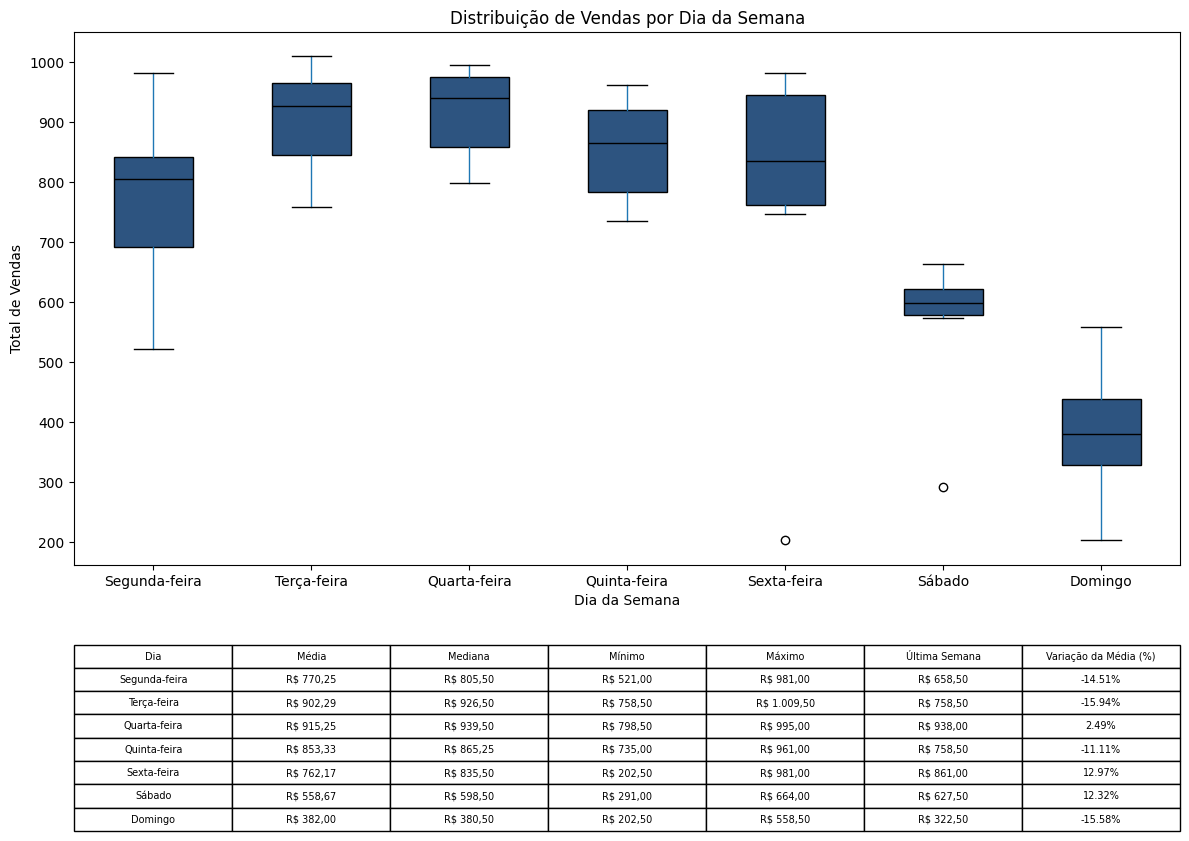

In [13]:
# Garantir tipo datetime
df_filtrado['data'] = pd.to_datetime(df_filtrado['data'], dayfirst=True, errors='coerce')

# Somar total por dia
df_dia = df_filtrado.groupby('data')['total'].sum().reset_index()
df_dia['dia_semana_en'] = df_dia['data'].dt.day_name()

# Traduzir nomes dos dias
df_dia['dia_semana'] = df_dia['dia_semana_en'].map(util.traducao_dias)

# Ordenar dias
ordem_dias_pt = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']
df_dia['dia_semana'] = pd.Categorical(df_dia['dia_semana'], categories=ordem_dias_pt, ordered=True)

# Estatísticas por dia da semana
estatisticas = df_dia.groupby('dia_semana', observed=True)['total'].agg(
    media='mean',
    mediana='median',
    minimo='min',
    maximo='max',
    desvio='std',
).reset_index()

# Último total por dia da semana
df_ultimo = df_dia.sort_values('data').groupby('dia_semana', observed=True).last().reset_index()
df_ultimo.rename(columns={'total': 'ultimo_total'}, inplace=True)

# Merge estatísticas com último total
df_stats = estatisticas.merge(df_ultimo[['dia_semana', 'ultimo_total']], on='dia_semana')

# Calcular variação percentual da última semana sobre a média
df_stats['variacao_%'] = (
    ((df_stats['ultimo_total'] - df_stats['media']) / df_stats['media']) * 100
).round(2).astype(str) + '%'

# Arredondar e formatar colunas de valores monetários
colunas_formatar = ['media', 'mediana', 'minimo', 'maximo', 'ultimo_total']
for col in colunas_formatar:
    df_stats[col] = df_stats[col].round(2).map(util.formata_para_brl)

# Plot: boxplot
fig, ax = plt.subplots(figsize=(12, 8))

df_dia.boxplot(column='total', by='dia_semana', ax=ax, grid=False, patch_artist=True,
               boxprops=dict(facecolor=util.barra_azul, color='black'),
               medianprops=dict(color='black'))

ax.set_title('Distribuição de Vendas por Dia da Semana')
ax.set_ylabel('Total de Vendas')
ax.set_xlabel('Dia da Semana')
plt.suptitle("")  # remover título automático do pandas
plt.xticks(rotation=0)

# Tabela estatística abaixo do gráfico
cols_tabela = ['dia_semana', 'media', 'mediana', 'minimo', 'maximo', 'ultimo_total', 'variacao_%']
col_labels = ['Dia', 'Média', 'Mediana', 'Mínimo', 'Máximo', 'Última Semana', 'Variação da Média (%)']

tabela = plt.table(
    cellText=df_stats[cols_tabela].values,
    colLabels=col_labels,
    cellLoc='center',
    loc='bottom',
    bbox=[0, -0.5, 1, 0.35]
)

plt.subplots_adjust(bottom=0.4)
plt.tight_layout()
plt.show()


### Distribuição Diária de Vendas por Fazenda (R$)

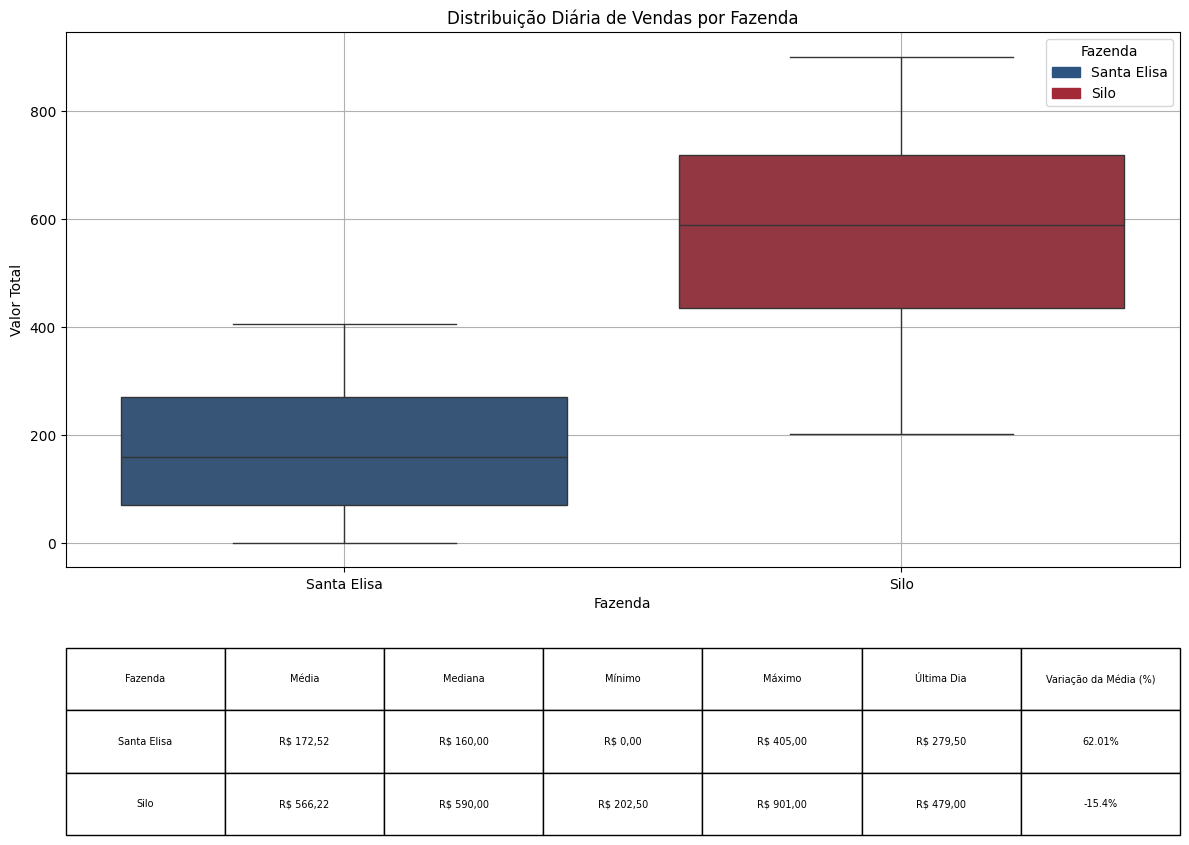

In [14]:
# Estatísticas por fazenda
df_stats = df_filtrado.groupby('fazenda')['total'].agg(['mean', 'median', 'min', 'max']).reset_index()
df_stats.columns = ['Fazenda', 'Média', 'Mediana', 'Mínimo', 'Máximo']

# Último total registrado por fazenda
df_ultimo = df_filtrado.sort_values('data').groupby('fazenda').last().reset_index()
df_ultimo = df_ultimo[['fazenda', 'total']]
df_ultimo.columns = ['Fazenda', 'Último Dia']

# Juntar
df_stats = df_stats.merge(df_ultimo, on='Fazenda')

# Calcular variação percentual da última semana sobre a média
df_stats['Variação da Média (%)'] = (
    ((df_stats['Último Dia'] - df_stats['Média']) / df_stats['Média']) * 100
).round(2)

df_stats['Variação da Média (%)'] = df_stats['Variação da Média (%)'].astype(str) + '%'


# Arredondar tudo para 2 casas
colunas_formatar = ['Média', 'Mediana', 'Mínimo', 'Máximo', 'Último Dia']
df_stats[colunas_formatar] = df_stats[colunas_formatar].round(2).map(util.formata_para_brl)


# Criar figura
fig, ax = plt.subplots(figsize=(12, 8))

# Boxplot
sns.boxplot(data=df_filtrado, x='fazenda', y='total', hue='fazenda',
            palette=[util.barra_azul, util.barra_vermelha], ax=ax, legend=False)

ax.set_title('Distribuição Diária de Vendas por Fazenda')
ax.set_xlabel('Fazenda')
ax.set_ylabel('Valor Total')
ax.grid(True)

# Legenda
legend_patches = [mpatches.Patch(color=cor, label=fazenda) for cor, fazenda in zip(
    [util.barra_azul, util.barra_vermelha], sorted(df_filtrado['fazenda'].unique()))]
ax.legend(handles=legend_patches, title='Fazenda')

# Reorganizar colunas para corresponder aos col_labels desejados
df_tabela = df_stats[['Fazenda', 'Média', 'Mediana', 'Mínimo', 'Máximo', 'Último Dia', 'Variação da Média (%)']]
col_labels = ['Fazenda', 'Média', 'Mediana', 'Mínimo', 'Máximo', 'Última Dia', 'Variação da Média (%)']

# Tabela
table = plt.table(cellText=df_tabela.values,
                  colLabels=col_labels,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.5, 1, 0.35])

plt.subplots_adjust(bottom=0.35)
plt.tight_layout()
plt.show()


### Ticket Médio por Refeição por Fazenda (R$)

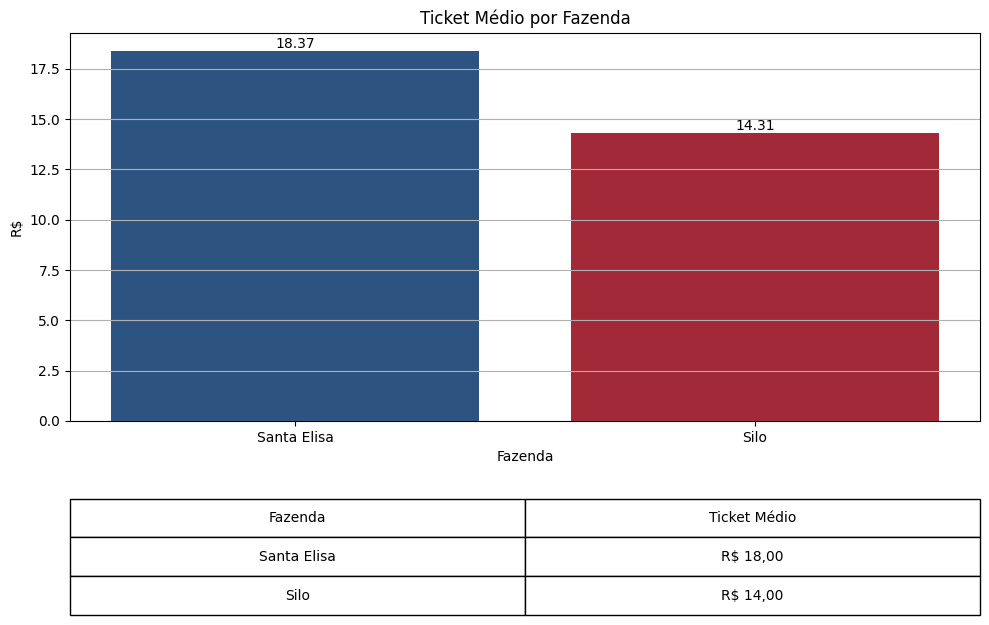

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

df_filtrado['qtd_total'] = df_filtrado[['almoco', 'janta', 'lanche', 'cafe']].sum(axis=1)
df_filtrado['ticket_medio'] = df_filtrado['total'] / df_filtrado['qtd_total'].replace(0, pd.NA)

ticket_fazenda = df_filtrado.groupby('fazenda')['ticket_medio'].mean()

cores = [util.barra_azul, util.barra_vermelha]
bars = ax.bar(ticket_fazenda.index, ticket_fazenda.values, color=cores)

ax.set_title('Ticket Médio por Fazenda')
ax.set_ylabel('R$')
ax.set_xlabel('Fazenda')
ax.grid(axis='y')
plt.xticks(rotation=0)

# Mostrar valores acima das barras
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}',
            ha='center', va='bottom')

# Criar tabela logo abaixo do gráfico
df_tabela = ticket_fazenda.reset_index()
df_tabela.columns = ['Fazenda', 'Ticket Médio']
df_tabela['Ticket Médio'] = df_tabela['Ticket Médio'].round(0).astype(int).apply(util.formata_para_brl)

table = plt.table(cellText=df_tabela.values,
                  colLabels=df_tabela.columns,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.5, 1, 0.3])

plt.subplots_adjust(bottom=0.35)
plt.tight_layout()
plt.show()

### Distribuição Ticket Médio por Refeição por Fazenda (R$)

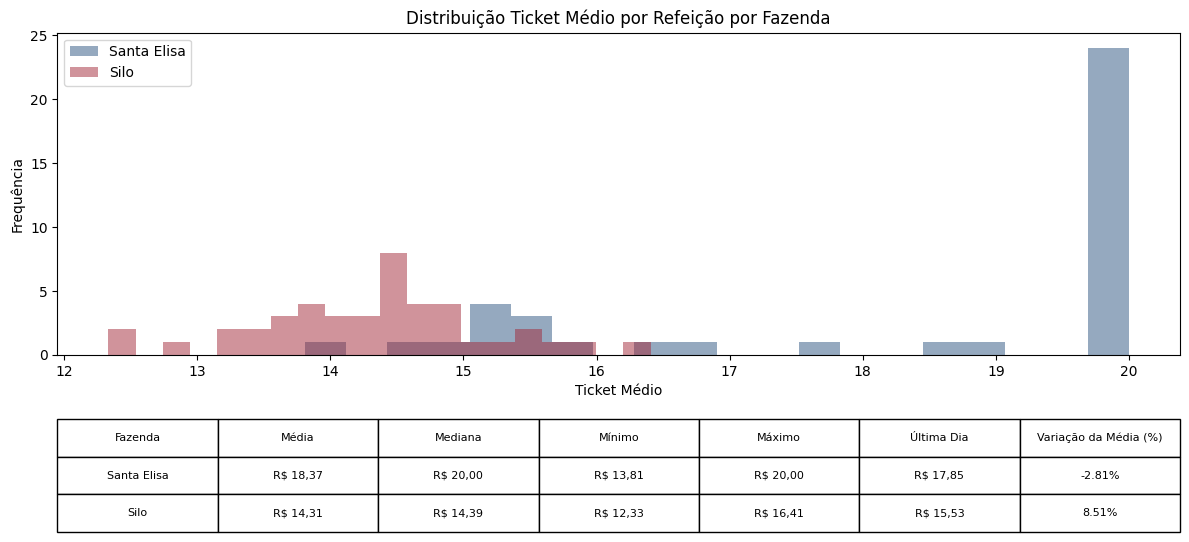

In [16]:
# Estatísticas descritivas do ticket médio por fazenda
df_stats = df_filtrado.groupby('fazenda')['ticket_medio'].agg(['min', 'mean', 'median', 'max']).reset_index()
df_stats.columns = ['Fazenda', 'Mínimo', 'Média', 'Mediana', 'Máximo']

# Exemplo: adicionando 'Último Dia' e 'Variação da Média (%)' (crie os dados ou adapte o cálculo real)
# Vou criar colunas fictícias para exemplo:
df_stats['Último Dia'] = df_stats['Média'] * (1 + np.random.uniform(-0.1, 0.1, size=len(df_stats)))  # simula valor
df_stats['Variação da Média (%)'] = ((df_stats['Último Dia'] - df_stats['Média']) / df_stats['Média']) * 100

# Arredondar valores e formatar para BRL
for col in ['Média', 'Mediana', 'Mínimo', 'Máximo', 'Último Dia']:
    df_stats[col] = df_stats[col].round(2).map(util.formata_para_brl)

# Formatando variação percentual com sinal e % no final
df_stats['Variação da Média (%)'] = df_stats['Variação da Média (%)'].round(2).map(lambda x: f"{x:.2f}%")

# Reordenar colunas conforme solicitado
df_tabela = df_stats[['Fazenda', 'Média', 'Mediana', 'Mínimo', 'Máximo', 'Último Dia', 'Variação da Média (%)']]

col_labels = ['Fazenda', 'Média', 'Mediana', 'Mínimo', 'Máximo', 'Última Dia', 'Variação da Média (%)']

# Plot histograma
fig, ax = plt.subplots(figsize=(12, 6))

cores_personalizadas = [util.barra_azul, util.barra_vermelha]
fazendas = df_filtrado['fazenda'].unique()

for i, fazenda in enumerate(fazendas):
    dados_fazenda = df_filtrado[df_filtrado['fazenda'] == fazenda]['ticket_medio'].dropna()
    ax.hist(dados_fazenda, bins=20, alpha=0.5, label=fazenda, color=cores_personalizadas[i % len(cores_personalizadas)])

ax.set_title('Distribuição Ticket Médio por Refeição por Fazenda')
ax.set_xlabel('Ticket Médio')
ax.set_ylabel('Frequência')
ax.legend()
plt.tight_layout()

# Tabela
table = plt.table(cellText=df_tabela.values,
                  colLabels=col_labels,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.55, 1, 0.35])

plt.subplots_adjust(bottom=0.4)
plt.show()

### Calor do volume total de refeições por dia da semana e fazenda

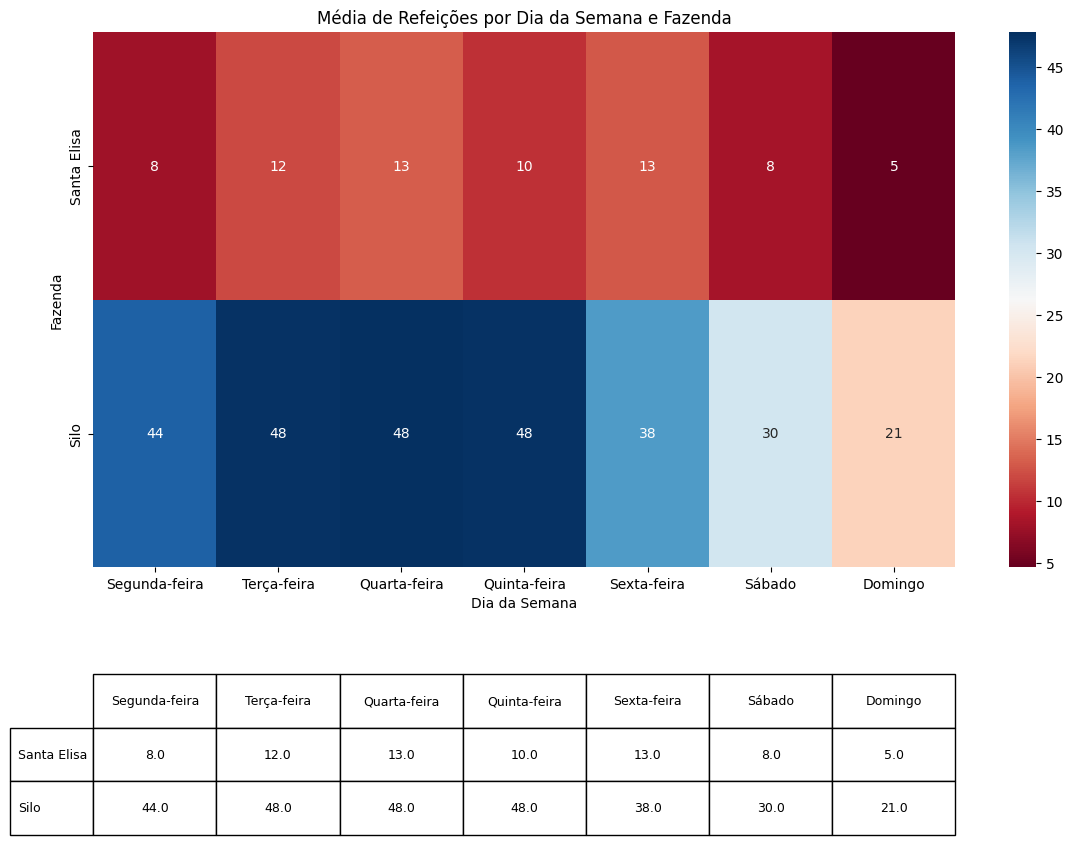

In [17]:
# Criar qtd_total somando tipos de refeição (se não existir)
if 'qtd_total' not in df_filtrado.columns:
    df_filtrado['qtd_total'] = df_filtrado[['almoco', 'janta', 'cafe', 'lanche']].sum(axis=1)

df_filtrado['dia_semana'] = df_filtrado['data'].dt.day_name()
df_filtrado['dia_semana'] = df_filtrado['dia_semana'].map({
    'Monday': 'Segunda-feira',
    'Tuesday': 'Terça-feira',
    'Wednesday': 'Quarta-feira',
    'Thursday': 'Quinta-feira',
    'Friday': 'Sexta-feira',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
})

pivot_table = df_filtrado.pivot_table(index='fazenda', columns='dia_semana',
                             values='qtd_total', aggfunc='mean')

dias_ordenados_pt = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']
pivot_table = pivot_table[dias_ordenados_pt]

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap='RdBu', ax=ax)
ax.set_title('Média de Refeições por Dia da Semana e Fazenda')
ax.set_xlabel('Dia da Semana')
ax.set_ylabel('Fazenda')

table = plt.table(cellText=pivot_table.round(0).values,
                  colLabels=pivot_table.columns,
                  rowLabels=pivot_table.index,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0, -0.5, 1, 0.3])

plt.subplots_adjust(bottom=0.35)
plt.tight_layout()
plt.show()


### Identificação de dias com vendas anormais (outliers de total vendido)

⚠️ Nenhum outlier encontrado para exibir na tabela.


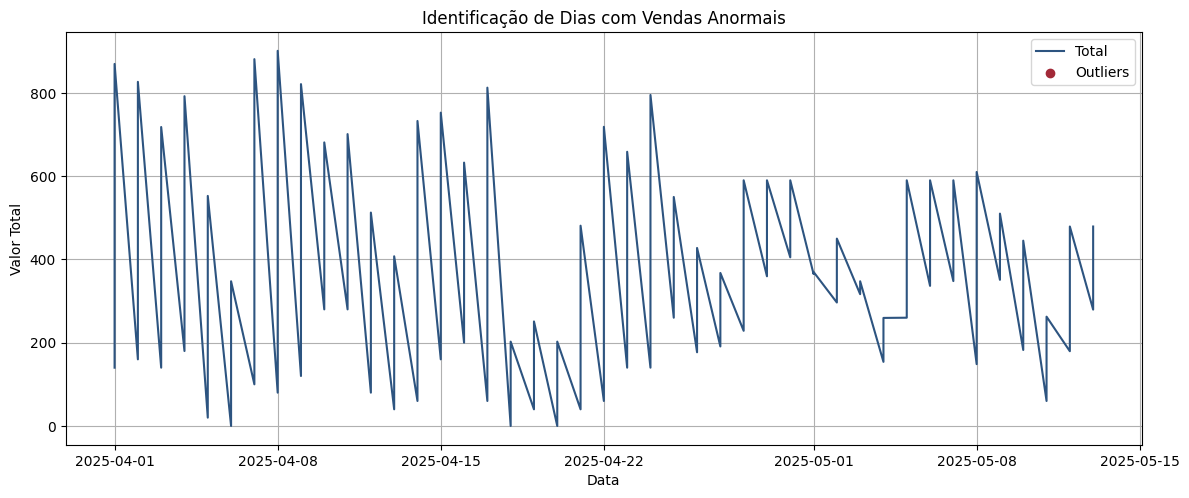

In [18]:
# Cálculo dos outliers com base no IQR do total vendido
q1 = df_filtrado['total'].quantile(0.25)
q3 = df_filtrado['total'].quantile(0.75)
iqr = q3 - q1
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

outliers = df_filtrado[(df_filtrado['total'] < limite_inferior) | (df_filtrado['total'] > limite_superior)]

# Definindo as cores
cores = [util.barra_azul, util.barra_vermelha]

# Plot principal com linha e pontos dos outliers
plt.figure(figsize=(12, 6))
plt.plot(df_filtrado['data'], df_filtrado['total'], color=cores[0], label='Total')
plt.scatter(outliers['data'], outliers['total'], color=cores[1], label='Outliers', zorder=5)
plt.title('Identificação de Dias com Vendas Anormais')
plt.xlabel('Data')
plt.ylabel('Valor Total')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Criar tabela com os últimos 7 outliers
tabela_outliers = outliers[['data', 'total']].tail(7).copy()

if not tabela_outliers.empty:
    tabela_outliers['data'] = tabela_outliers['data'].dt.strftime('%Y-%m-%d')

    plt.table(cellText=tabela_outliers.values,
              colLabels=['Data', 'Valor Total'],
              cellLoc='center',
              rowLoc='center',
              loc='bottom',
              bbox=[0, -0.5, 1, 0.3])

    plt.subplots_adjust(bottom=0.25)
else:
    print("⚠️ Nenhum outlier encontrado para exibir na tabela.")

plt.subplots_adjust(bottom=0.25)  # Ajusta o espaço para a tabela aparecer
plt.show()

### Séries Temporais por Tipo de Refeição (Previsão)

/home/rafael/App/dashboard_elisaagro/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
16:36:31 - cmdstanpy - INFO - Chain [1] start processing
16:36:31 - cmdstanpy - INFO - Chain [1] done processing


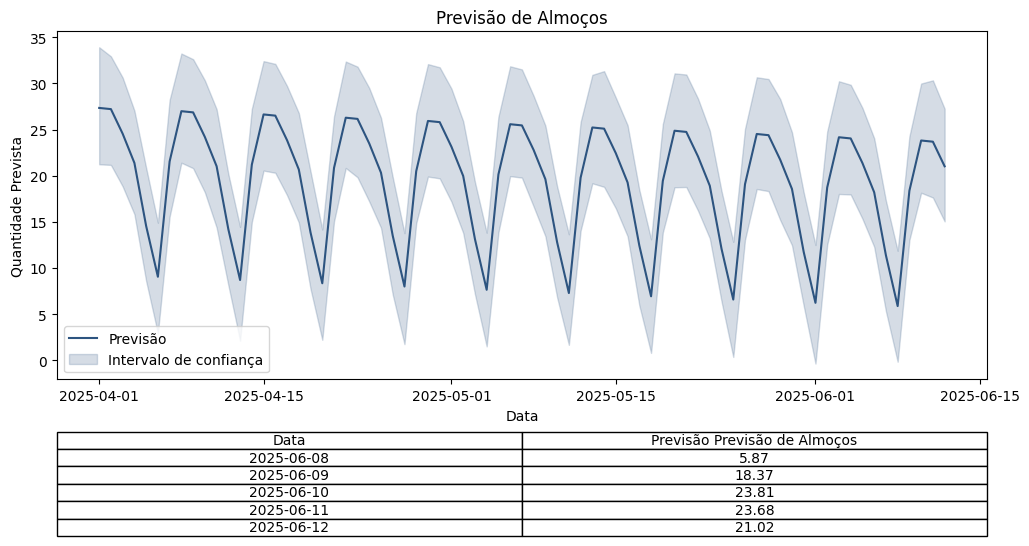

16:36:31 - cmdstanpy - INFO - Chain [1] start processing
16:36:31 - cmdstanpy - INFO - Chain [1] done processing


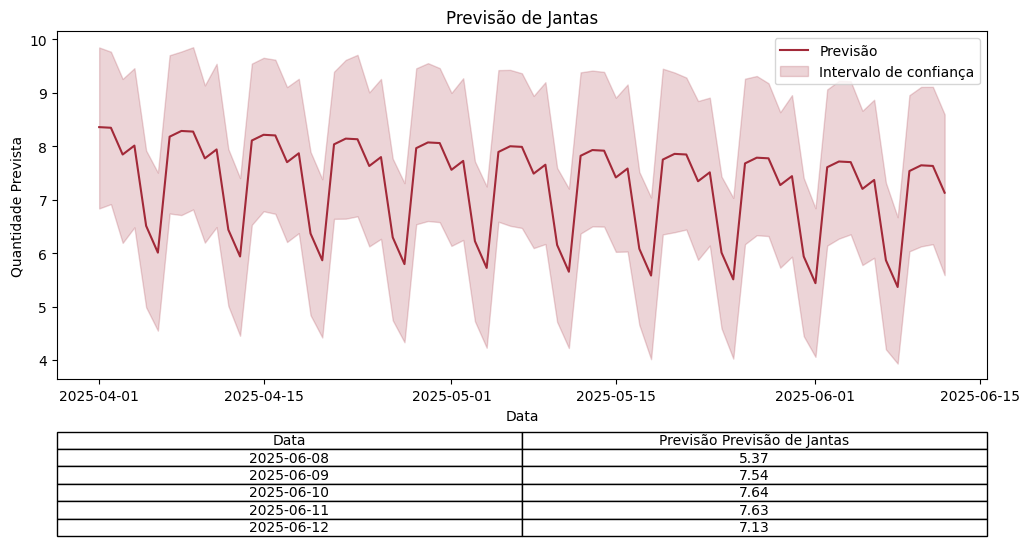

16:36:32 - cmdstanpy - INFO - Chain [1] start processing
16:36:32 - cmdstanpy - INFO - Chain [1] done processing


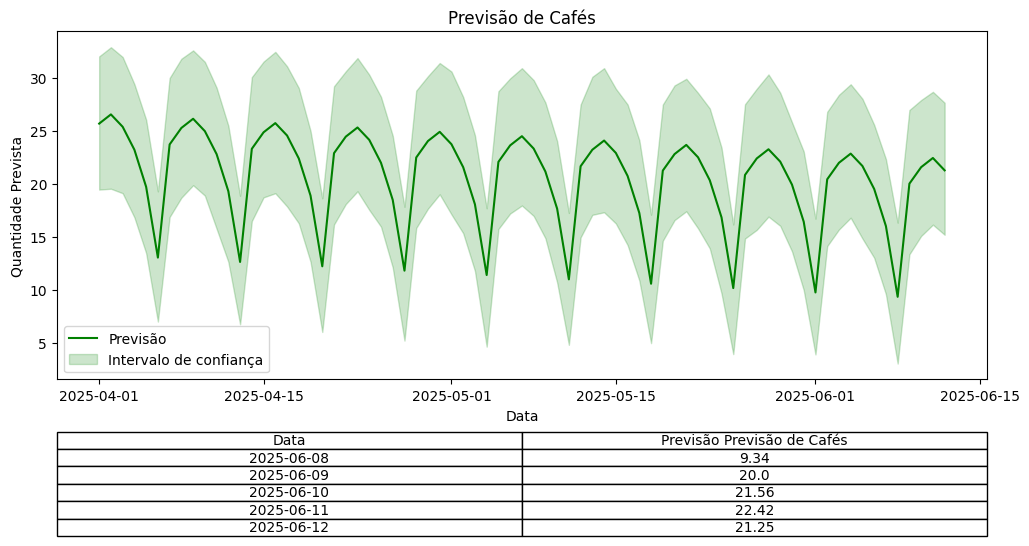

16:36:32 - cmdstanpy - INFO - Chain [1] start processing
16:36:32 - cmdstanpy - INFO - Chain [1] done processing


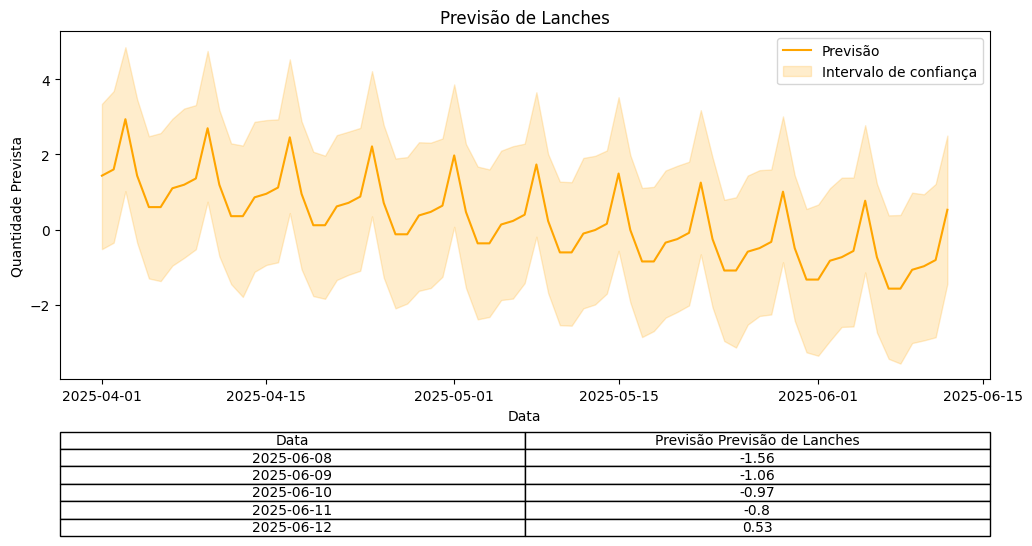

In [19]:
from prophet import Prophet

def prever_e_plotar(df_filtrado, coluna, titulo, cor):
    # Agrupa por data somando a coluna desejada
    df_serie = df_filtrado.groupby('data')[coluna].sum().reset_index()
    df_serie.columns = ['ds', 'y']
    
    # Cria e treina o modelo Prophet
    modelo = Prophet()
    modelo.fit(df_serie)
    
    # Gera datas futuras (30 dias)
    futuro = modelo.make_future_dataframe(periods=30)
    previsao = modelo.predict(futuro)
    
    # Plotagem do gráfico com intervalo de confiança
    plt.figure(figsize=(12, 6))
    plt.plot(previsao['ds'], previsao['yhat'], color=cor, label='Previsão')
    plt.fill_between(previsao['ds'], previsao['yhat_lower'], previsao['yhat_upper'],
                     color=cor, alpha=0.2, label='Intervalo de confiança')
    plt.title(titulo)
    plt.xlabel('Data')
    plt.ylabel('Quantidade Prevista')
    plt.legend()
    
    # Tabela com os últimos 7 dias previstos
    tabela_prev = previsao[['ds', 'yhat']].tail(5).copy()
    tabela_prev['ds'] = tabela_prev['ds'].dt.strftime('%Y-%m-%d')
    tabela_prev['yhat'] = tabela_prev['yhat'].round(2)

    plt.table(cellText=tabela_prev.values,
              colLabels=['Data', f'Previsão {titulo}'],
              cellLoc='center',
              loc='bottom',
              bbox=[0.0, -0.45, 1.0, 0.3])  
    plt.subplots_adjust(bottom=0.3)
    plt.show()

# Chamar a função para cada tipo
prever_e_plotar(df_filtrado, 'almoco', 'Previsão de Almoços', util.barra_azul)
prever_e_plotar(df_filtrado, 'janta', 'Previsão de Jantas', util.barra_vermelha)
prever_e_plotar(df_filtrado, 'cafe', 'Previsão de Cafés', 'green')
prever_e_plotar(df_filtrado, 'lanche', 'Previsão de Lanches', 'orange')


### Séries Temporais por Tipo de Refeição e por Fazenda (Previsão)

16:36:32 - cmdstanpy - INFO - Chain [1] start processing
16:36:32 - cmdstanpy - INFO - Chain [1] done processing


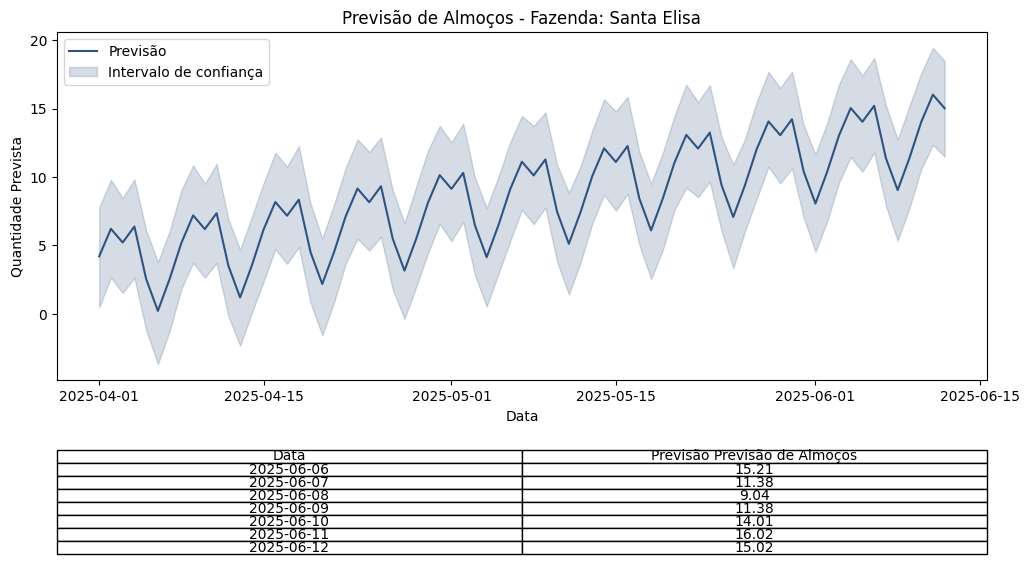

16:36:32 - cmdstanpy - INFO - Chain [1] start processing
16:36:32 - cmdstanpy - INFO - Chain [1] done processing


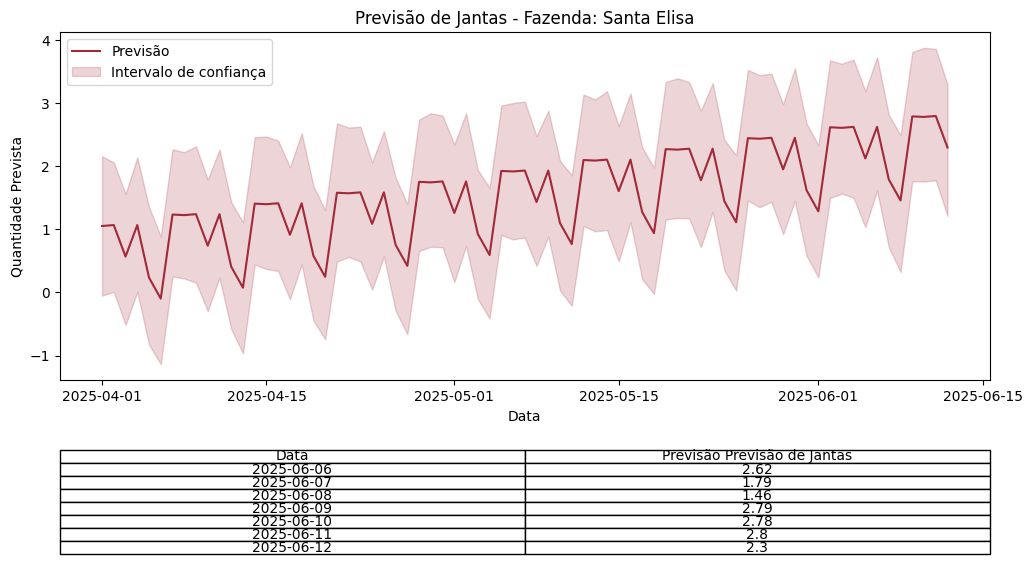

16:36:32 - cmdstanpy - INFO - Chain [1] start processing
16:36:32 - cmdstanpy - INFO - Chain [1] done processing


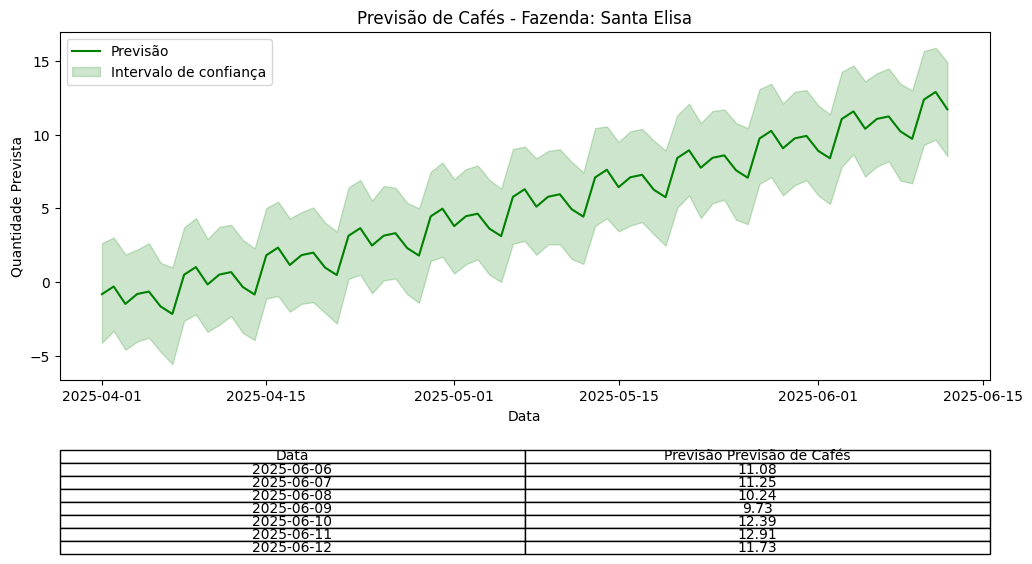

16:36:32 - cmdstanpy - INFO - Chain [1] start processing
16:36:33 - cmdstanpy - INFO - Chain [1] done processing


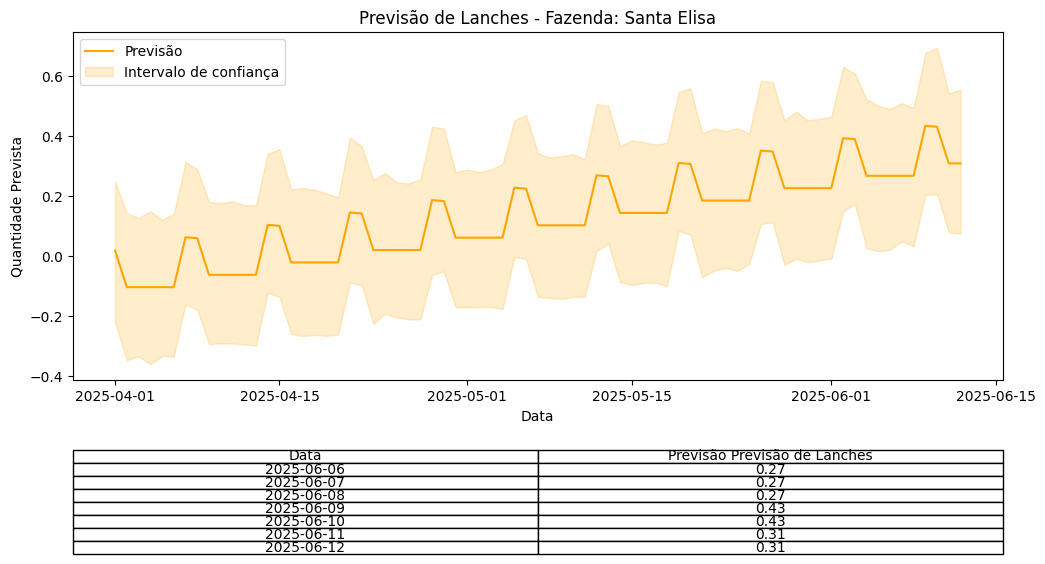

16:36:33 - cmdstanpy - INFO - Chain [1] start processing
16:36:33 - cmdstanpy - INFO - Chain [1] done processing


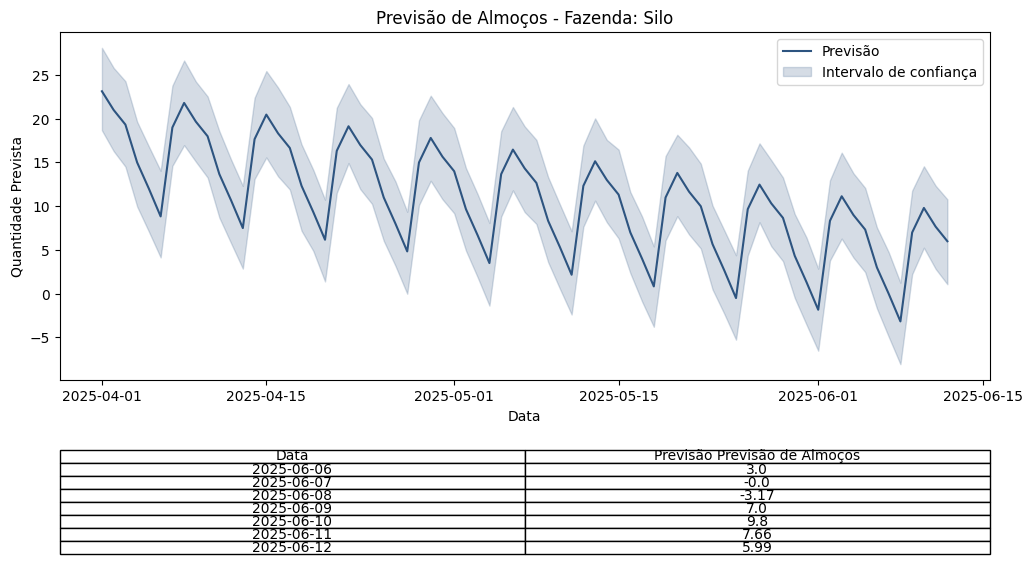

16:36:33 - cmdstanpy - INFO - Chain [1] start processing
16:36:33 - cmdstanpy - INFO - Chain [1] done processing


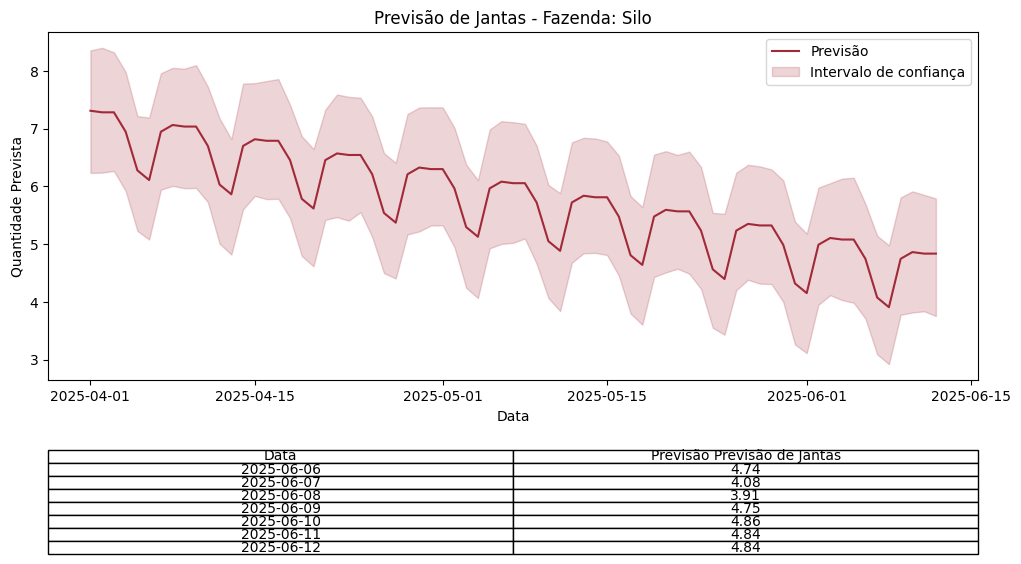

16:36:33 - cmdstanpy - INFO - Chain [1] start processing
16:36:33 - cmdstanpy - INFO - Chain [1] done processing


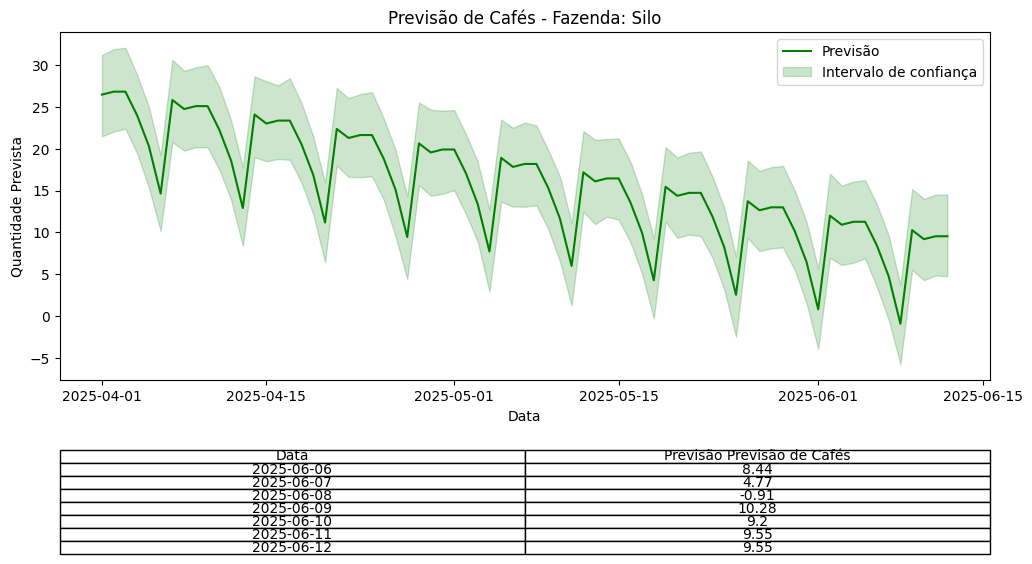

16:36:33 - cmdstanpy - INFO - Chain [1] start processing
16:36:33 - cmdstanpy - INFO - Chain [1] done processing


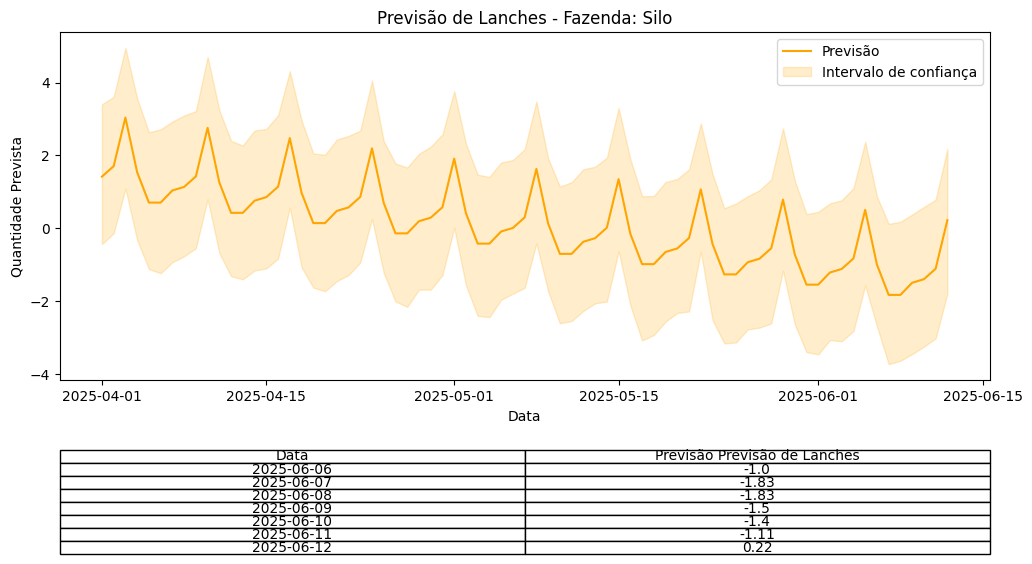

In [20]:
def prever_e_plotar_por_fazenda(df_filtrado, fazenda, coluna, titulo, cor):
    # Filtra só os dados da fazenda desejada
    df_fazenda = df_filtrado[df_filtrado['fazenda'] == fazenda]
    
    # Agrupa por data e soma a coluna desejada
    df_serie = df_fazenda.groupby('data')[coluna].sum().reset_index()
    df_serie.columns = ['ds', 'y']
    
    if df_serie['y'].sum() == 0:
        print(f"Sem dados para {titulo} na fazenda {fazenda}. Pulando...")
        return
    
    modelo = Prophet()
    modelo.fit(df_serie)
    
    futuro = modelo.make_future_dataframe(periods=30)
    previsao = modelo.predict(futuro)
    
    plt.figure(figsize=(12, 6))
    plt.plot(previsao['ds'], previsao['yhat'], color=cor, label='Previsão')
    plt.fill_between(previsao['ds'], previsao['yhat_lower'], previsao['yhat_upper'],
                     color=cor, alpha=0.2, label='Intervalo de confiança')
    plt.title(f'{titulo} - Fazenda: {fazenda}')
    plt.xlabel('Data')
    plt.ylabel('Quantidade Prevista')
    plt.legend()
    
    tabela_prev = previsao[['ds', 'yhat']].tail(7).copy()
    tabela_prev['ds'] = tabela_prev['ds'].dt.strftime('%Y-%m-%d')
    tabela_prev['yhat'] = tabela_prev['yhat'].round(2)
    
    plt.table(cellText=tabela_prev.values,
              colLabels=['Data', f'Previsão {titulo}'],
              cellLoc='center',
              loc='bottom',
              bbox=[0, -0.5, 1, 0.3])
    
    plt.subplots_adjust(bottom=0.3)
    plt.show()

# Pega todas as fazendas únicas
fazendas = df_filtrado['fazenda'].unique()

# Cores para os tipos de refeição (pode ajustar)
cores = {
    'almoco': util.barra_azul,
    'janta': util.barra_vermelha,
    'cafe': 'green',
    'lanche': 'orange'
}

# Roda para todas as fazendas e tipos
for f in fazendas:
    prever_e_plotar_por_fazenda(df_filtrado, f, 'almoco', 'Previsão de Almoços', cores['almoco'])
    prever_e_plotar_por_fazenda(df_filtrado, f, 'janta', 'Previsão de Jantas', cores['janta'])
    prever_e_plotar_por_fazenda(df_filtrado, f, 'cafe', 'Previsão de Cafés', cores['cafe'])
    prever_e_plotar_por_fazenda(df_filtrado, f, 'lanche', 'Previsão de Lanches', cores['lanche'])
